In [5]:
# !pip install matplotlib tqdm numpy

In [6]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.plotters import plot_average_execution_time
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [7]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [ ]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    # subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    # print(subfolders)
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        num_tasks = 100
        print(f"Evaluating algorithm: {config['alg'].name}")
        
        times = []
        
        for i in range(10):
            print(f"Evaluating test {i + 1} of {10}")
            schedule_stats = review_task_sets_in_parallel_multi(
                algorithm=config["alg"],
                folder_name=folder_name,
                num_processors=config["processors"],
                #num_clusters=config["clusters"],
                heuristic=config["heuristic"],
                number_of_workers=worker_quantity)
                # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
                # execution_times[num_tasks] = success_rate
            end_time = time() - start_time
            times.append(end_time)
        average_time = np.mean(times)
        print(average_time)

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": average_time
            }
        )

    return execution_times

In [9]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "sorting": 'du',
        "processors": 8,
        #"clusters": 4,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")


Executing with: 1 workers.
Evaluating test 1 of 10
Total files considered: 1000
Evaluating test 2 of 10
Total files considered: 1000
Evaluating test 3 of 10
Total files considered: 1000
Evaluating test 4 of 10
Total files considered: 1000
Evaluating test 5 of 10
Total files considered: 1000
Evaluating test 6 of 10
Total files considered: 1000
Evaluating test 7 of 10
Total files considered: 1000
Evaluating test 8 of 10
Total files considered: 1000
Evaluating test 9 of 10
Total files considered: 1000
Evaluating test 10 of 10
Total files considered: 1000
8.790232753753662
Executing with: 2 workers.
Evaluating test 1 of 10
Total files considered: 1000
Evaluating test 2 of 10
Total files considered: 1000
Evaluating test 3 of 10
Total files considered: 1000
Evaluating test 4 of 10
Total files considered: 1000
Evaluating test 5 of 10
Total files considered: 1000
Evaluating test 6 of 10
Total files considered: 1000
Evaluating test 7 of 10
Total files considered: 1000
Evaluating test 8 of 10
To

Time taken for 1 workers: 8.790232753753662
Time taken for 2 workers: 5.35783314704895
Time taken for 3 workers: 4.484944486618042
Time taken for 4 workers: 4.135253262519837
Time taken for 5 workers: 3.7373322248458862
Time taken for 6 workers: 3.532625150680542
Time taken for 7 workers: 3.4899672985076906
Time taken for 8 workers: 3.822203493118286
Time taken for 9 workers: 3.632135033607483
Time taken for 10 workers: 3.6858983755111696
Time taken for 11 workers: 3.646716904640198
Time taken for 12 workers: 4.4056398391723635
Time taken for 13 workers: 4.321676898002624
Time taken for 14 workers: 4.079609155654907
Time taken for 15 workers: 4.454570889472961
Time taken for 16 workers: 4.202801465988159
Time taken for 17 workers: 3.942149043083191
Time taken for 18 workers: 4.092181086540222
Time taken for 19 workers: 4.04173436164856
Time taken for 20 workers: 4.084737491607666
Time taken for 21 workers: 4.506459784507752
Time taken for 22 workers: 4.5028825283050535
Time taken for 2

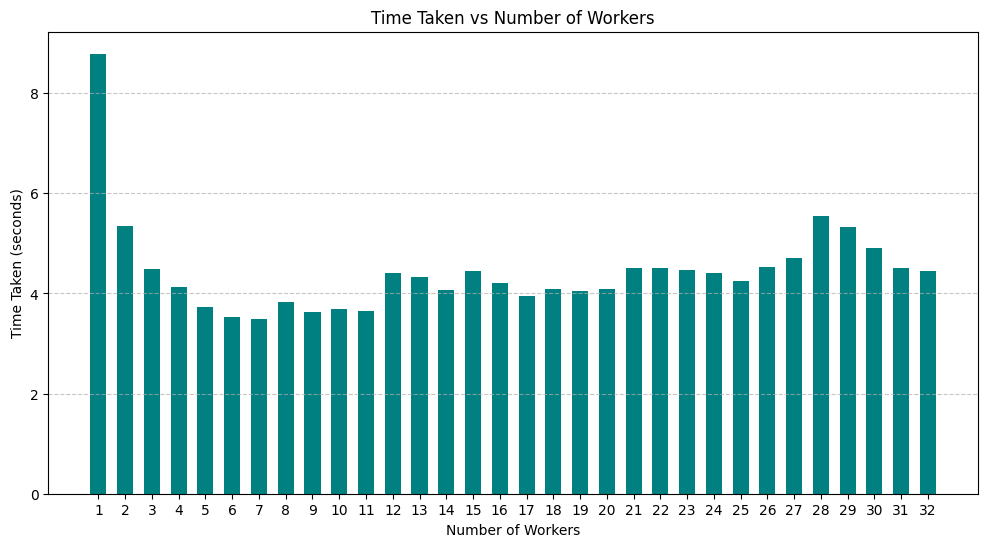

In [17]:
for result in results:
    print(f"Time taken for {result['workers']} workers: {result['time']}")

workers = [result["workers"] for result in results]
times = [result["time"] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(workers, times, color='teal', width=0.6)
plt.xlabel('Number of Workers')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Workers')
plt.xticks(workers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()